In [2]:
import os
import shutil
import librosa
import soundfile as sf
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# === CONFIGURACIÓN ===
ORIG_GOOGLE = "speech_commands"
ORIG_ESC50 = "ESC-50-master"
ESC50_META = "ESC-50-master/meta/esc50.csv"
DESTINO = "dataset_final"
DURACION = 1.0  # segundos

# === CLASES A USAR ===

google_clases = [
    "yes", "no"
]

esc50_clases = {
    "aplauso": "clapping",
    "chasquido": "finger_snapping",
    "silencio": ["vacuum_cleaner", "wind", "white_noise"]
}

# === FUNCIONES ===

def copiar_google():
    for clase in google_clases:
        origen = os.path.join(ORIG_GOOGLE, clase)
        destino = os.path.join(DESTINO, clase)
        os.makedirs(destino, exist_ok=True)
        for f in os.listdir(origen):
            if f.endswith(".wav"):
                shutil.copy(os.path.join(origen, f), os.path.join(destino, f))

def recortar_y_guardar(audio_path, destino, clase, duracion=DURACION):
    y, sr = librosa.load(audio_path, sr=None)
    total = int(len(y) / sr)
    for i in range(0, total):
        start = int(i * sr)
        end = int((i + duracion) * sr)
        if end > len(y):
            break
        fragmento = y[start:end]
        nombre = f"{Path(audio_path).stem}_{i}.wav"
        carpeta_clase = os.path.join(destino, clase)
        os.makedirs(carpeta_clase, exist_ok=True)
        sf.write(os.path.join(carpeta_clase, nombre), fragmento, sr)

def procesar_esc50():
    meta = pd.read_csv(ESC50_META)
    for nombre_clase, etiquetas in esc50_clases.items():
        etiquetas = [etiquetas] if isinstance(etiquetas, str) else etiquetas
        subset = meta[meta["category"].isin(etiquetas)]
        for _, fila in tqdm(subset.iterrows(), total=len(subset), desc=nombre_clase):
            archivo = os.path.join(ORIG_ESC50, "audio", fila["filename"])
            recortar_y_guardar(archivo, DESTINO, nombre_clase)

# === EJECUCIÓN ===

if __name__ == "__main__":
    print("📦 Copiando audios de Google Speech Commands...")
    copiar_google()
    print("✂️ Procesando y recortando audios de ESC-50...")
    procesar_esc50()
    print("✅ Dataset final creado en:", DESTINO)


📦 Copiando audios de Google Speech Commands...
✂️ Procesando y recortando audios de ESC-50...


aplauso: 100%|██████████| 40/40 [00:01<00:00, 36.41it/s]
chasquido: 0it [00:00, ?it/s]
silencio: 100%|██████████| 80/80 [00:00<00:00, 257.14it/s]

✅ Dataset final creado en: dataset_final


In [3]:
import os

DATASET_DIR = "dataset_final"
total = 0

for clase in os.listdir(DATASET_DIR):
    clase_path = os.path.join(DATASET_DIR, clase)
    if not os.path.isdir(clase_path):
        continue
    count = len([f for f in os.listdir(clase_path) if f.endswith(".wav")])
    print(f"{clase}: {count} archivos")
    total += count

print(f"Total: {total} archivos de audio encontrados")


silencio: 400 archivos
no: 3941 archivos
aplauso: 200 archivos
yes: 4044 archivos
Total: 8585 archivos de audio encontrados


In [4]:
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Parámetros
SAMPLE_RATE = 16000
DURATION = 1  # segundos
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MFCC = 13
N_FFT = 512
HOP_LENGTH = 256
EXPECTED_FRAMES = 1 + (SAMPLES_PER_TRACK - N_FFT) // HOP_LENGTH  # ≈ 61

# Directorio base
DATASET_PATH = 'dataset_final'  # Cambiá si hace falta

# Inicializamos
X = []
y = []

# Procesamos audios
for label in sorted(os.listdir(DATASET_PATH)):
    label_path = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(label_path):
        continue

    for file in tqdm(os.listdir(label_path), desc=f"Procesando {label}"):
        file_path = os.path.join(label_path, file)

        try:
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Pad o truncar a 1 segundo
            if len(signal) < SAMPLES_PER_TRACK:
                pad_width = SAMPLES_PER_TRACK - len(signal)
                signal = np.pad(signal, (0, pad_width), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_TRACK]

            # Extraer MFCCs
            mfcc = librosa.feature.mfcc(
                y=signal,
                sr=sr,
                n_mfcc=N_MFCC,
                n_fft=N_FFT,
                hop_length=HOP_LENGTH
            )

            # Asegurar tamaño (61, 13)
            if mfcc.shape[1] < EXPECTED_FRAMES:
                pad_width = EXPECTED_FRAMES - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            elif mfcc.shape[1] > EXPECTED_FRAMES:
                mfcc = mfcc[:, :EXPECTED_FRAMES]

            # Agregar a listas
            X.append(mfcc.T)  # Transponer para (frames, coeficientes)
            y.append(label)

        except Exception as e:
            print(f"Error con {file_path}: {e}")

# Convertimos a arrays
X = np.array(X, dtype=np.float32)
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Clases: {le.classes_}")


Procesando yes: 100%|██████████| 4044/4044 [00:35<00:00, 113.47it/s]

X shape: (8585, 61, 13), y shape: (8585,)
Clases: ['aplauso' 'no' 'silencio' 'yes']


In [5]:
# Crear diccionario para codificar etiquetas
labels = sorted(set(y))  # Obtener todas las clases únicas en orden alfabético
label_to_index = {label: idx for idx, label in enumerate(labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}


In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Asegurarse de que X tiene la forma (samples, 61, 13, 1)
X = np.expand_dims(X, -1)

# Codificar etiquetas
y_encoded = to_categorical([label_to_index[label] for label in y])

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)


In [7]:
# Definir modelo CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(61,13,1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(y_encoded.shape[1], activation='softmax')  # salida con número de clases
])


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [8]:
# Compilar modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


2025-04-10 20:34:27.191668: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


172/172 [==============================] - 4s 19ms/step - loss: 1.3497 - accuracy: 0.8023 - val_loss: 0.2334 - val_accuracy: 0.9258
Epoch 2/20
172/172 [==============================] - 3s 16ms/step - loss: 0.2942 - accuracy: 0.8955 - val_loss: 0.1473 - val_accuracy: 0.9498
Epoch 3/20
172/172 [==============================] - 3s 18ms/step - loss: 0.2030 - accuracy: 0.9299 - val_loss: 0.1478 - val_accuracy: 0.9527
Epoch 4/20
172/172 [==============================] - 3s 18ms/step - loss: 0.1678 - accuracy: 0.9419 - val_loss: 0.1187 - val_accuracy: 0.9592
Epoch 5/20
172/172 [==============================] - 3s 18ms/step - loss: 0.1376 - accuracy: 0.9521 - val_loss: 0.0954 - val_accuracy: 0.9672
Epoch 6/20
172/172 [==============================] - 3s 18ms/step - loss: 0.1201 - accuracy: 0.9570 - val_loss: 0.0978 - val_accuracy: 0.9723
Epoch 7/20
172/172 [==============================] - 3s 18ms/step - loss: 0.0991 - accuracy: 0.9641 - val_loss: 0.0803 - val_accuracy: 0.9709
Epoch 8/20

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import keras

# Evaluar el modelo con los datos de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")



54/54 [==============================] - 1s 11ms/step - loss: 0.0722 - accuracy: 0.9802

Test Accuracy: 0.9802


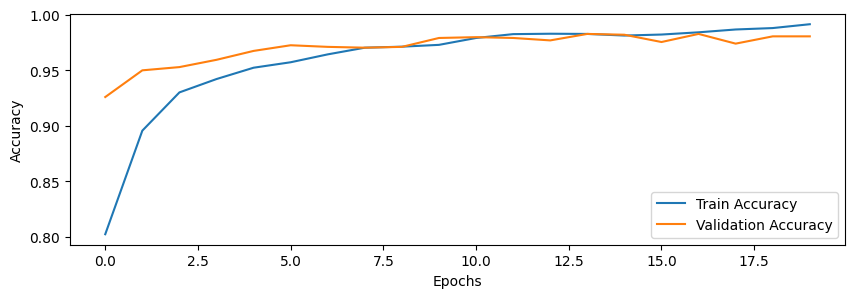

In [10]:
plt.figure(figsize=(10,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


54/54 [==============================] - 0s 3ms/step
ROC AUC Score (weighted): 0.9991281622778734


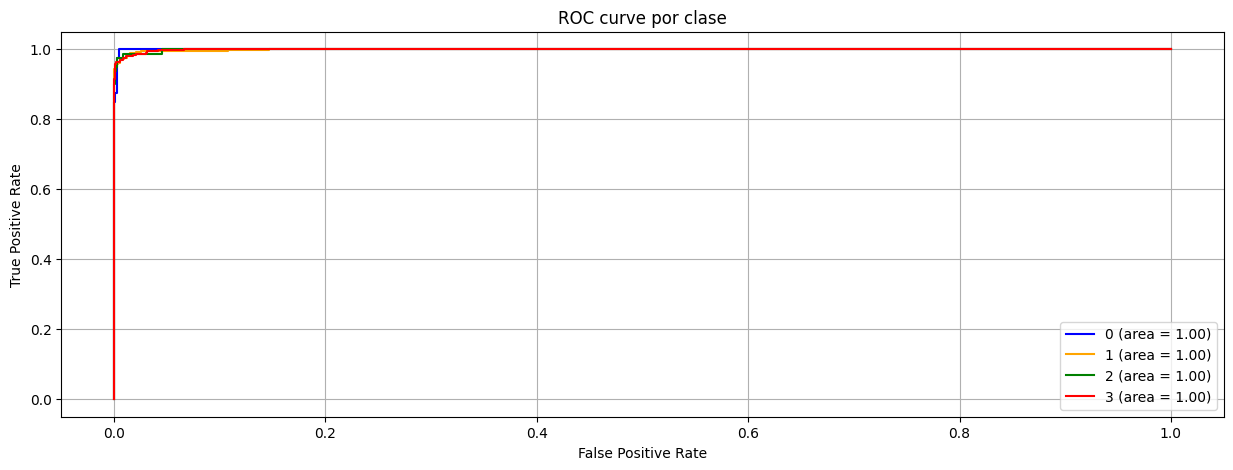

In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Obtener predicciones probabilísticas
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Etiquetas verdaderas en one-hot
num_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print("ROC AUC Score (weighted):", roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted'))

# Graficar curvas ROC
import matplotlib.pyplot as plt

colors = ['blue','orange','green','red']
plt.figure(figsize=(15,5))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], label=f'{index_to_label[i]} (area = {roc_auc[i]:.2f})')

plt.title('ROC curve por clase')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()


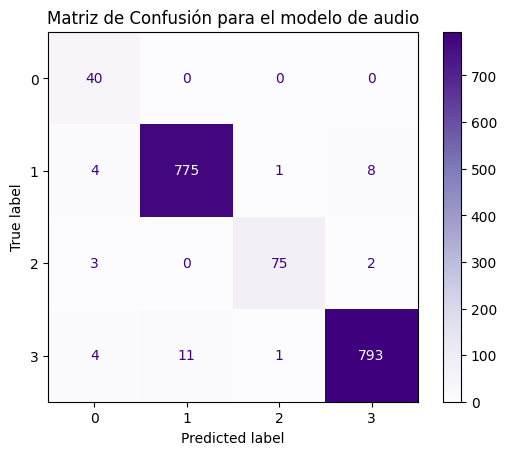

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[index_to_label[i] for i in range(num_classes)])
disp.plot(cmap='Purples')
plt.title('Matriz de Confusión para el modelo de audio')
plt.show()


In [15]:
# Guardar el modelo
model.save('models/modelo_mfcc_cnn.h5')
print("✅ Modelo guardado en 'models/modelo_mfcc_cnn.h5'")

✅ Modelo guardado en 'models/modelo_mfcc_cnn.h5'
